In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras import layers
from tensorflow.keras import models

### Exploration of data

In [2]:
data_dir = "../data"  

# Funcion para contar número de imagenes en cada carpeta
def count_images_folders(root_dir):
    total = 0
    category_counts = {}
    for folder in os.listdir(root_dir):
        folder_path = os.path.join(root_dir, folder)
        if os.path.isdir(folder_path):
            emotion_count = {}
            num_images =  len(os.listdir(folder_path))             
            print(f"{num_images} images in {folder} folder")
            total += num_images
            category_counts[folder] = num_images
    print(f"Total images: {total}")
    return category_counts


# Contamos imagenes en train y test
print("Train Folder:")
train_category_counts = count_images_folders(os.path.join(data_dir, "train1"))

print("\nValidation Folder:")
validation_category_counts = count_images_folders(os.path.join(data_dir, "validation"))

print("\nTest Folder:")
test_category_counts = count_images_folders(os.path.join(data_dir, "test"))


Train Folder:
1998 images in angry folder
218 images in disgust folder
2049 images in fear folder
3608 images in happy folder
2483 images in neutral folder
2415 images in sad folder
1586 images in surprise folder
Total images: 14357

Validation Folder:
1997 images in angry folder
218 images in disgust folder
2048 images in fear folder
3607 images in happy folder
2482 images in neutral folder
2415 images in sad folder
1585 images in surprise folder
Total images: 14352

Test Folder:
958 images in angry folder
111 images in disgust folder
1024 images in fear folder
1774 images in happy folder
1233 images in neutral folder
1247 images in sad folder
831 images in surprise folder
Total images: 7178


+ Distribution of classes in train, validation and test:

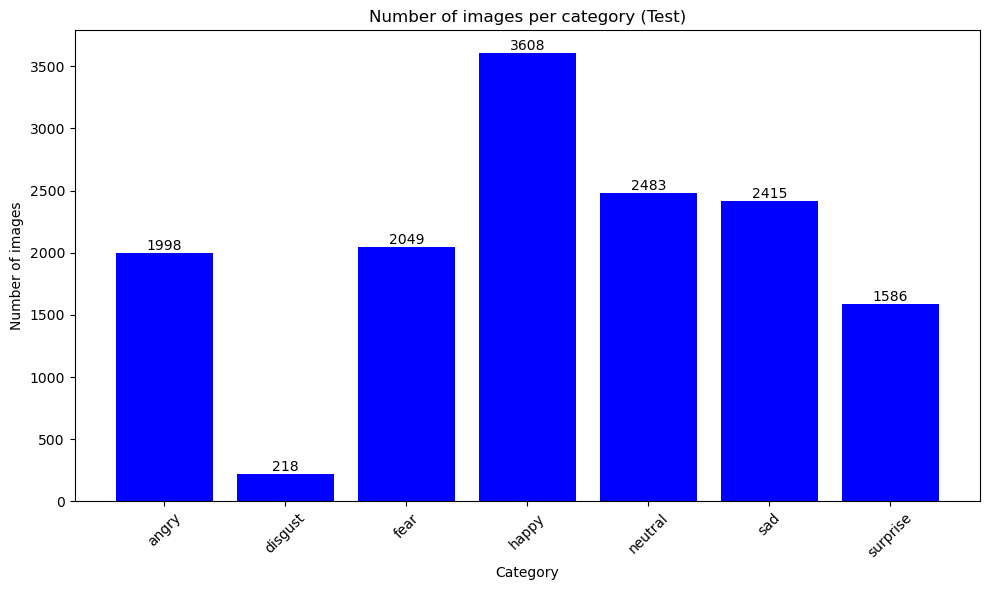

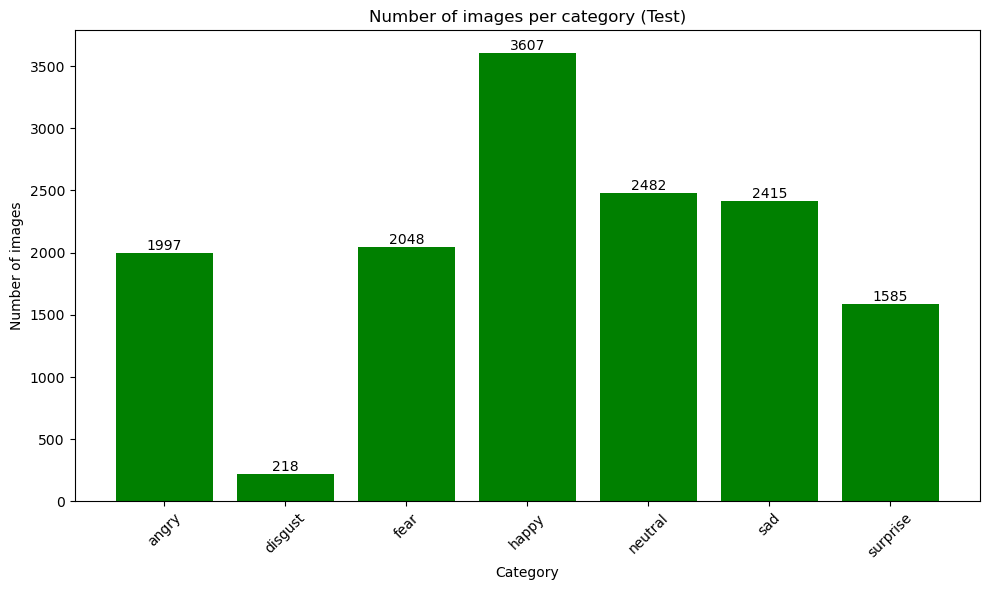

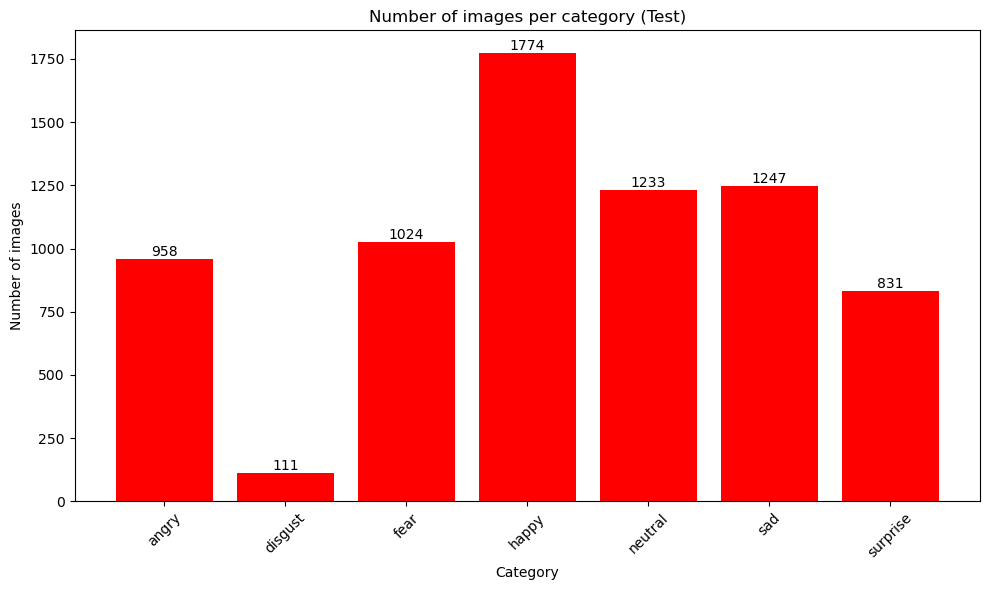

In [3]:
#Training
plt.figure(figsize=(10, 6))
plt.bar(train_category_counts.keys(), train_category_counts.values(), color='blue')
bars = plt.bar(train_category_counts.keys(), train_category_counts.values(), color='blue')
plt.title('Number of images per category (Test)')
plt.xlabel('Category')
plt.ylabel('Number of images')
plt.xticks(rotation=45)
plt.tight_layout()
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom', ha='center')

plt.show()

#Validation
plt.figure(figsize=(10, 6))
plt.bar(validation_category_counts.keys(), validation_category_counts.values(), color='green')
bars = plt.bar(validation_category_counts.keys(), validation_category_counts.values(), color='green')
plt.title('Number of images per category (Test)')
plt.xlabel('Category')
plt.ylabel('Number of images')
plt.xticks(rotation=45)
plt.tight_layout()
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom', ha='center')

plt.show()

#Test
plt.figure(figsize=(10, 6))
plt.bar(test_category_counts.keys(), test_category_counts.values(), color='red')
bars = plt.bar(test_category_counts.keys(), test_category_counts.values(), color='red')
plt.title('Number of images per category (Test)')
plt.xlabel('Category')
plt.ylabel('Number of images')
plt.xticks(rotation=45)
plt.tight_layout()
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom', ha='center')

plt.show()

### Search of CNN from scratch

In this part, we have conducted a search of the paremeters and structure of our CNN using keras-tuner.

In [4]:

# Define data directories
train_dir = "../data/train1"
validation_dir = "../data/validation"
test_dir = "../data/test"

# Image dimensions and other parameters
img_width, img_height = 48, 48
batch_size = 64

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


In [5]:
# Generate batches of image data (train and validation)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)


Found 14357 images belonging to 7 classes.
Found 14352 images belonging to 7 classes.


In [6]:
from tensorflow.keras import layers

def build_model(hp):
    model = models.Sequential()
    model.add(layers.Conv2D(
        filters=hp.Choice('conv_filters_1', values=[16,32, 64, 96, 128]),
        kernel_size=hp.Choice('conv_kernel_1', values=[3, 5]),
        activation='relu',
        input_shape=(img_width, img_height, 3),
        padding='same'
    ))
    model.add(layers.MaxPooling2D(pool_size=(2, 2),padding='same'))
    
    # Add additional convolutional layers
    for i in range(hp.Int('num_conv_layers', 1, 6)):  # Adjust the range for the number of convolutional layers
        model.add(layers.Conv2D(
            filters=hp.Choice(f'conv_filters_{i+2}', values=[16,32, 64, 96, 128]),
            kernel_size=hp.Choice(f'conv_kernel_{i+2}', values=[3, 5]),
            activation='relu',
            padding='same'
        ))
        model.add(layers.MaxPooling2D(pool_size=(2, 2),padding='same'))

    model.add(layers.Flatten())

    # Add dense layers
    for i in range(hp.Int('num_dense_layers', 1, 4)):  # Adjust the range for the number of dense layers
        model.add(layers.Dense(
            units=hp.Choice(f'dense_units_{i+1}', values=[32, 64, 96, 128,256]),
            activation='relu'
        ))

    model.add(layers.Dense(7, activation='softmax'))
    
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model


In [7]:
from keras_tuner.tuners import BayesianOptimization


In [8]:
from keras import callbacks
tuner = BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=200,
    executions_per_trial=1,
    overwrite=False,
    directory='tuner_results',
    project_name='cnn_tuning'
)


Reloading Tuner from tuner_results\cnn_tuning\tuner0.json


In [9]:

# Perform Hyperparameter Tuning
tuner.search(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[callbacks.EarlyStopping(patience=5, monitor='val_accuracy')]
)

Trial 200 Complete [00h 03m 30s]
val_accuracy: 0.5398550629615784

Best val_accuracy So Far: 0.5441053509712219
Total elapsed time: 07h 27m 56s


In [10]:
tuner.results_summary()

Results summary
Results in tuner_results\cnn_tuning
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 153 summary
Hyperparameters:
conv_filters_1: 16
conv_kernel_1: 3
num_conv_layers: 3
conv_filters_2: 128
conv_kernel_2: 5
num_dense_layers: 2
dense_units_1: 256
conv_filters_3: 128
conv_kernel_3: 3
conv_filters_4: 128
conv_kernel_4: 5
conv_filters_5: 128
conv_kernel_5: 5
conv_filters_6: 96
conv_kernel_6: 5
dense_units_2: 32
dense_units_3: 128
dense_units_4: 32
conv_filters_7: 16
conv_kernel_7: 3
Score: 0.5441053509712219

Trial 123 summary
Hyperparameters:
conv_filters_1: 16
conv_kernel_1: 3
num_conv_layers: 4
conv_filters_2: 96
conv_kernel_2: 5
num_dense_layers: 1
dense_units_1: 32
conv_filters_3: 128
conv_kernel_3: 3
conv_filters_4: 128
conv_kernel_4: 3
conv_filters_5: 96
conv_kernel_5: 5
conv_filters_6: 16
conv_kernel_6: 5
dense_units_2: 256
dense_units_3: 256
dense_units_4: 32
conv_filters_7: 32
conv_kernel_7: 3
Score: 0.5415970087051392

Trial 107 summar

In [11]:
tuner.get_best_models()[0]

In [12]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 7178 images belonging to 7 classes.


The best model is given by trial nº153 that has the hyperparameteters shown below:

In [13]:
# Get Best Model
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Hyperparameters: {best_hyperparameters.values}")

# Evaluate Best Model
loss, accuracy = best_model.evaluate(test_generator, verbose=2)
print(f"Test Accuracy: {accuracy}")

Best Hyperparameters: {'conv_filters_1': 16, 'conv_kernel_1': 3, 'num_conv_layers': 3, 'conv_filters_2': 128, 'conv_kernel_2': 5, 'num_dense_layers': 2, 'dense_units_1': 256, 'conv_filters_3': 128, 'conv_kernel_3': 3, 'conv_filters_4': 128, 'conv_kernel_4': 5, 'conv_filters_5': 128, 'conv_kernel_5': 5, 'conv_filters_6': 96, 'conv_kernel_6': 5, 'dense_units_2': 32, 'dense_units_3': 128, 'dense_units_4': 32, 'conv_filters_7': 16, 'conv_kernel_7': 3}
113/113 - 5s - loss: 1.2575 - accuracy: 0.5458 - 5s/epoch - 48ms/step
Test Accuracy: 0.545834481716156


In [14]:
best_hyperparameters.get('num_conv_layers')

3

In [15]:
best_hyperparameters.get('num_dense_layers')

2

In [16]:
tuner.results_summary()

Results summary
Results in tuner_results\cnn_tuning
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 153 summary
Hyperparameters:
conv_filters_1: 16
conv_kernel_1: 3
num_conv_layers: 3
conv_filters_2: 128
conv_kernel_2: 5
num_dense_layers: 2
dense_units_1: 256
conv_filters_3: 128
conv_kernel_3: 3
conv_filters_4: 128
conv_kernel_4: 5
conv_filters_5: 128
conv_kernel_5: 5
conv_filters_6: 96
conv_kernel_6: 5
dense_units_2: 32
dense_units_3: 128
dense_units_4: 32
conv_filters_7: 16
conv_kernel_7: 3
Score: 0.5441053509712219

Trial 123 summary
Hyperparameters:
conv_filters_1: 16
conv_kernel_1: 3
num_conv_layers: 4
conv_filters_2: 96
conv_kernel_2: 5
num_dense_layers: 1
dense_units_1: 32
conv_filters_3: 128
conv_kernel_3: 3
conv_filters_4: 128
conv_kernel_4: 3
conv_filters_5: 96
conv_kernel_5: 5
conv_filters_6: 16
conv_kernel_6: 5
dense_units_2: 256
dense_units_3: 256
dense_units_4: 32
conv_filters_7: 32
conv_kernel_7: 3
Score: 0.5415970087051392

Trial 107 summar